In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from logorama import logger

from bokeh.io import output_notebook, curdoc
from bokeh.plotting import figure, show
from bokeh.themes import Theme
from bokeh.embed import components
from bokeh.models import Range1d
from bokeh.palettes import Spectral10

%matplotlib inline

In [2]:
plot_theme = Theme("./theme.yml")

In [3]:
output_notebook()

Loading BokehJS ...

In [4]:
def save_plot(p, name, root_dir="./"):
    script, div = components(p)
    
    with open(f"{root_dir}/{name}_div.html", "w") as f:
        f.write(div)
    with open(f"{root_dir}/{name}_script.html", "w") as f:
        f.write(script)

In [5]:
sns.set_style(style="dark")

In [6]:
prostate_data = pd.read_csv("https://web.stanford.edu/~hastie/ElemStatLearn/datasets/prostate.data", 
                            sep="\t", index_col=0)
train_idx = prostate_data["train"] == "T"
prostate_data.drop(columns="train", inplace=True)

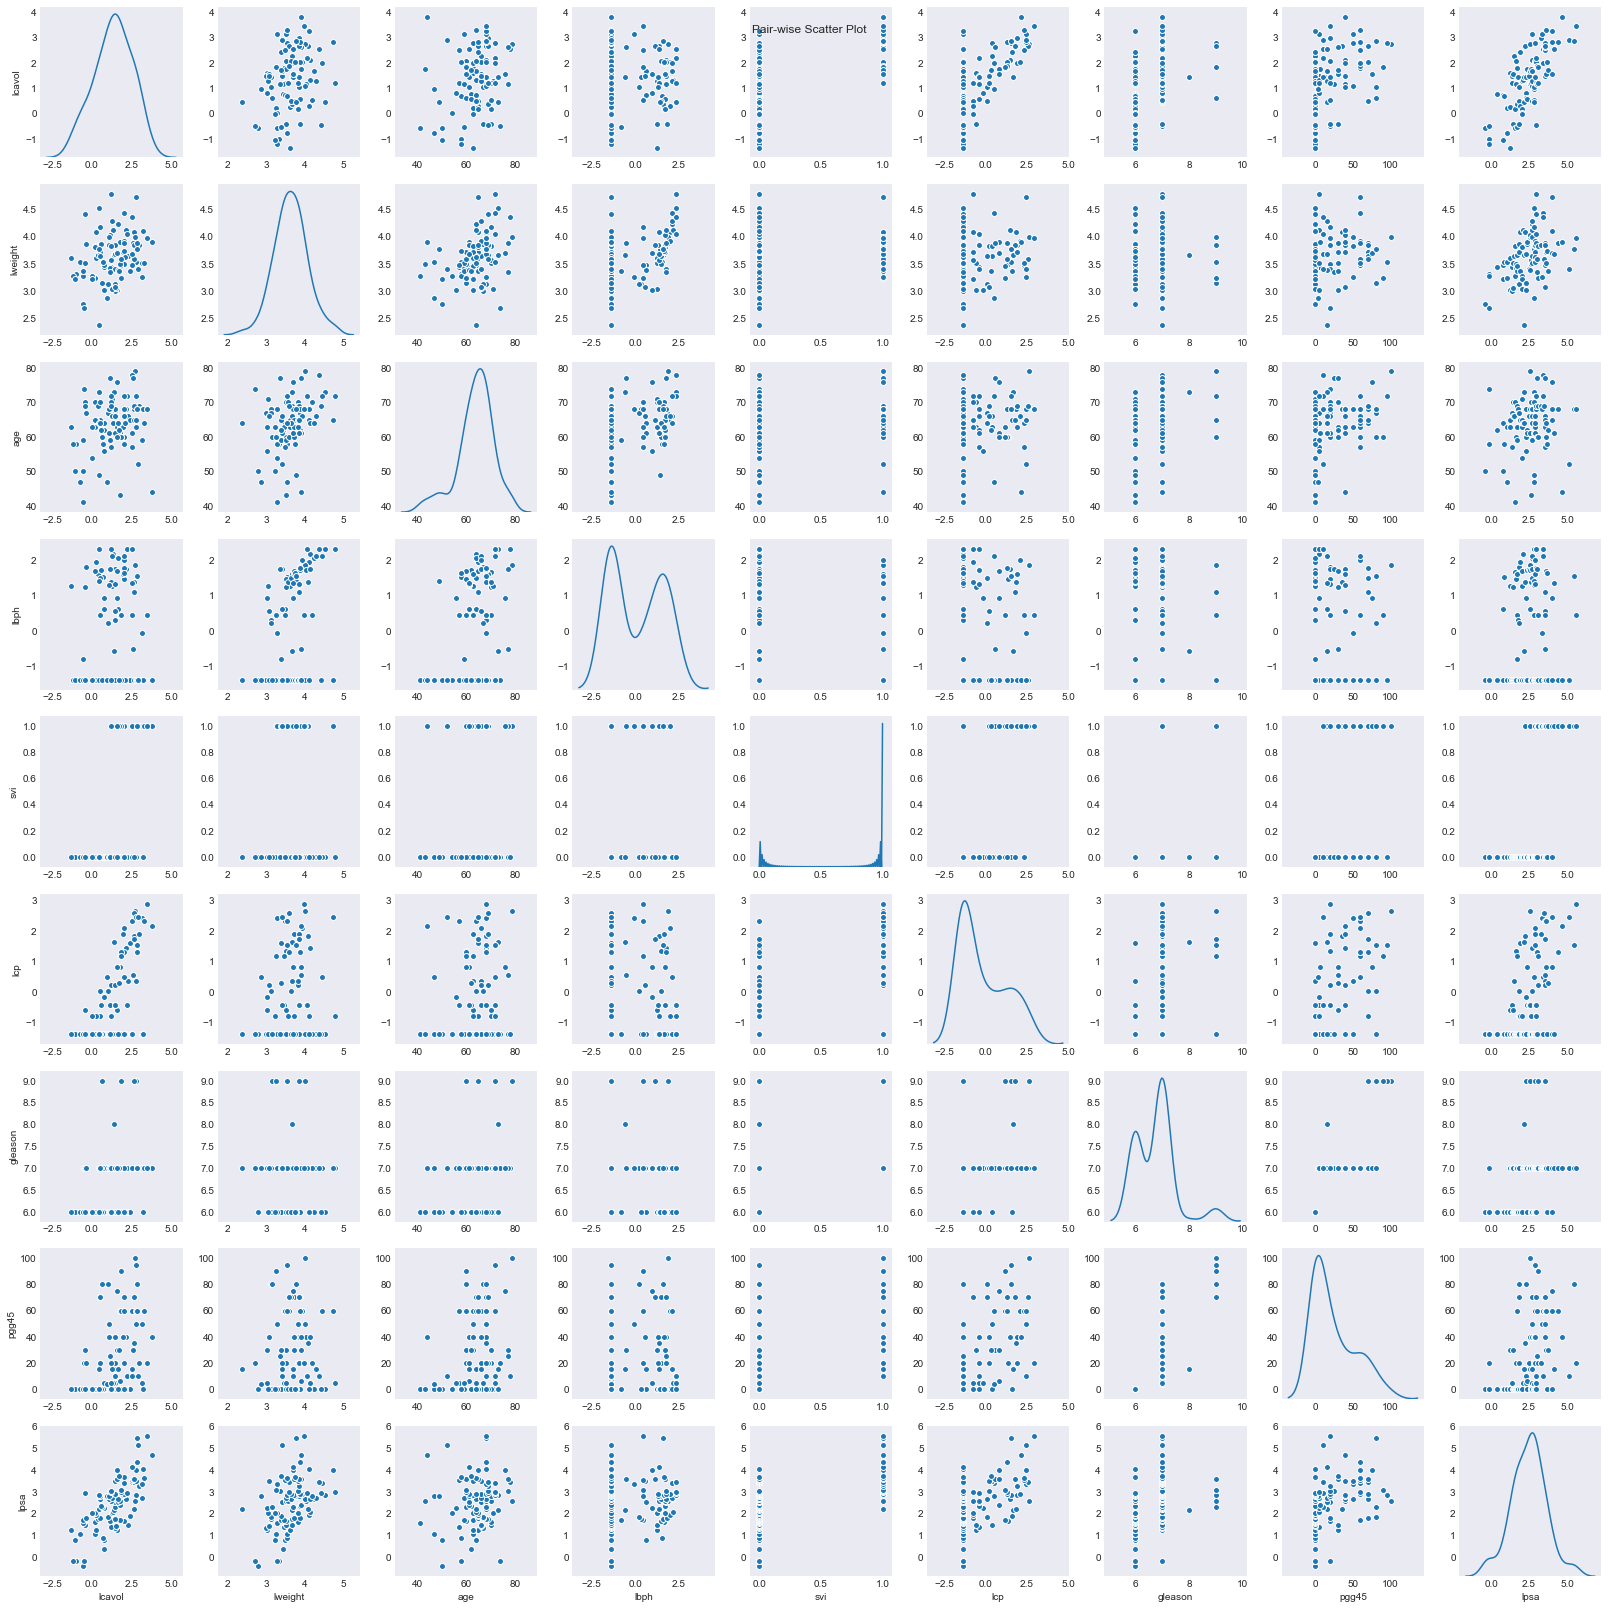

In [7]:
fp = sns.pairplot(prostate_data, diag_kind="kde")
fp.fig.suptitle("Pair-wise Scatter Plot")
plt.show()

In [8]:
import scipy.optimize as so

def norm(betas, x_train, y_train):
    return np.linalg.norm(y_train - np.mean(y_train) - x_train.dot(betas))

In [9]:
y_data = prostate_data["lpsa"]

x_data = prostate_data.drop(columns="lpsa")
x_data = (x_data - x_data.mean()) / x_data.std()

In [12]:
x_train = x_data.loc[train_idx]
x_train = np.hstack([np.ones((len(x_train), 1)), x_train.values.copy()])
y_train = y_data.loc[train_idx]

betas = np.linalg.inv(x_train.T.dot(x_train)).dot(x_train.T).dot(y_train)

y_train_hat = x_train.dot(betas) 

In [13]:
dof = len(x_train) - len(betas)

mse = np.sum((y_train_hat - y_train) ** 2) / dof

betas_cov = np.linalg.inv(x_train.T.dot(x_train)) * mse
betas_se = np.sqrt(betas_cov.diagonal())
betas_z = (betas - 0) / betas_se

betas_estimate_table = pd.DataFrame({"Beta": betas, "SE": betas_se, "Z-Score": betas_z}, 
                                    index=np.append(["intercept"], x_data.columns))

logger.info(f"Degrees of Freedom: {dof}")
logger.info(f"MSE: {np.round(mse, 4)}")
logger.info(f"Beta Errors:\n{betas_estimate_table}")

2018-09-09 22:01:45.493907 - [INFO] - {root:<module>:12} - Degrees of Freedom: 58
2018-09-09 22:01:45.495292 - [INFO] - {root:<module>:13} - MSE: 0.5074
2018-09-09 22:01:45.499882 - [INFO] - {root:<module>:14} - Beta Errors:
               Beta        SE    Z-Score
intercept  2.464933  0.089315  27.598203
lcavol     0.679528  0.126629   5.366290
lweight    0.263053  0.095628   2.750789
age       -0.141465  0.101342  -1.395909
lbph       0.210147  0.102219   2.055846
svi        0.305201  0.123600   2.469255
lcp       -0.288493  0.154529  -1.866913
gleason   -0.021305  0.145247  -0.146681
pgg45      0.266956  0.153614   1.737840


In [15]:
x_test = x_data.loc[~train_idx]
x_test = np.hstack([np.ones((len(x_test), 1)), x_test.values.copy()])
y_test = y_data.loc[~train_idx]

y_test_hat = x_test.dot(betas) 


dof_test = len(x_test) - len(betas)
mse = np.sum((y_test_hat - y_test) ** 2) / dof_test

logger.info(f"MSE: {np.round(mse, 4)}")

2018-09-09 22:03:04.121414 - [INFO] - {root:<module>:11} - MSE: 0.7447


## Ridge 

In [12]:
ridge_coeffs = np.append([0], np.logspace(0, 5.0, 21))
x_train = x_data.loc[train_idx].values.copy()
y_train = y_data.loc[train_idx].copy()
y_train = y_train - np.mean(y_train)

In [13]:
betas_ridge = {}
for lambdaa in ridge_coeffs:
    betas = np.linalg.inv(x_train.T.dot(x_train) + 
                          lambdaa * np.identity(len(x_train[0]))).dot(x_train.T).dot(y_train)
    df_lambda = np.trace(x_train.dot(np.linalg.inv(x_train.T.dot(x_train) + 
                          lambdaa * np.identity(len(x_train[0])))).dot(x_train.T))
    betas_ridge[df_lambda] = pd.Series(np.append(betas, [lambdaa]), index=np.append(x_data.columns, ["Lambda"]))
betas_ridge = pd.DataFrame(betas_ridge).T

In [14]:
p = figure(plot_width=800, plot_height=600)

for col, color in zip(x_data.columns, Spectral10):
    p.line(x=betas_ridge.index, y=betas_ridge[col].values, legend=col, color=color)
    p.circle(x=betas_ridge.index, y=betas_ridge[col].values, legend=col, color=color)
    
    
p.title.text = "Coefficient Shrinkage in Ridge Regression"
p.xaxis.axis_label = "df(\u03BB)"
p.yaxis.axis_label = "Coefficient"
p.legend.location = "top_left"

curdoc().clear()
doc = curdoc()
doc.theme = plot_theme
doc.add_root(p)
show(p)
save_plot(p, "lambda_ridge",  "/Users/kapilsharma/dev/git/kapilsh.github.io/_includes/bokeh/regularization/")

In [15]:
p = figure(plot_width=800, plot_height=600)

for col, color in zip(x_data.columns, Spectral10):
    p.line(x=np.log10(betas_ridge["Lambda"].values), y=betas_ridge[col].values, legend=col, color=color)
    p.circle(x=np.log10(betas_ridge["Lambda"].values), y=betas_ridge[col].values, legend=col, color=color)
    
    
p.title.text = "Coefficient Shrinkage in Ridge Regression (Beta vs log(lambda))"
p.xaxis.axis_label = "log\u2081\u2080(\u03BB)"
p.yaxis.axis_label = "Coefficient"
p.legend.location = "top_right"

curdoc().clear()
doc = curdoc()
doc.theme = plot_theme
doc.add_root(p)
show(p)
save_plot(p, "lambda_ridge_logl",  "/Users/kapilsharma/dev/git/kapilsh.github.io/_includes/bokeh/regularization/")

/Users/kapilsharma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/Users/kapilsharma/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


In [16]:
ols_beta_norm = np.linalg.norm(betas_estimate_table.Beta.values[1:])

ridge_coeffs = np.linspace(0, ols_beta_norm, 21)
x_train = x_data.loc[train_idx].values.copy()
y_train = y_data.loc[train_idx].copy()
y_train = y_train - np.mean(y_train)

def fit_ridge(t, x_train, y_train):
    return so.minimize(
        fun=norm, x0=np.zeros(len(x_train[0])),
        constraints={
            "type": "ineq",
            "fun": lambda x: t - np.linalg.norm(x)
        },
        args=(x_train, y_train)
    )

betas_ridge = {}

for t in ridge_coeffs:
    result = fit_ridge(t, x_train=x_train, y_train=y_train)
    shrink_coeff = t / ols_beta_norm
    betas_ridge[shrink_coeff] = pd.Series(result.x, index=x_data.columns)

betas_ridge = pd.DataFrame(betas_ridge).T
betas_ridge.sort_index(inplace=True)

In [17]:
p = figure(plot_width=800, plot_height=600)

for col, color in zip(x_data.columns, Spectral10):
    p.line(x=betas_ridge.index, y=betas_ridge[col].values, legend=col, color=color)
    p.circle(x=betas_ridge.index, y=betas_ridge[col].values, legend=col, color=color)
    
    
p.title.text = "Coefficient Shrinkage in Ridge Regression"
p.xaxis.axis_label = "Shrinkage Factor: t / ||\u03B2||\u2082"
p.yaxis.axis_label = "Coefficient"
p.legend.location = "top_left"

curdoc().clear()
doc = curdoc()
doc.theme = plot_theme
doc.add_root(p)
show(p)
save_plot(p, "lambda_ridge_t",  "/Users/kapilsharma/dev/git/kapilsh.github.io/_includes/bokeh/regularization/")

## Lasso

In [18]:
lasso_coeffs = np.linspace(0, 10, 21)
x_train = x_data.loc[train_idx].values.copy()
y_train = y_data.loc[train_idx].copy()
y_train = y_train - np.mean(y_train)

def modified_norm(betas, x_train, y_train, coeff):
    return norm(betas=betas, x_train=x_train, y_train=y_train) + coeff * np.sum(np.abs(betas))
    
def fit_lasso(lambdaa, x_train, y_train):
    return so.minimize(
        fun=modified_norm, x0=np.zeros(len(x_train[0])),
        args=(x_train, y_train, lambdaa)
    )

betas_lasso = {}

for lambdaa in lasso_coeffs:
    result = fit_lasso(lambdaa, x_train=x_train, y_train=y_train)
    betas_lasso[lambdaa] = pd.Series(result.x, index=x_data.columns)
    
betas_lasso = pd.DataFrame(betas_lasso).T
betas_lasso.sort_index(inplace=True)

In [19]:
p = figure(plot_width=800, plot_height=600)

for col, color in zip(x_data.columns, Spectral10):
    p.line(x=betas_lasso.index, y=betas_lasso[col].values, legend=col, color=color)
    p.circle(x=betas_lasso.index, y=betas_lasso[col].values, legend=col, color=color)
    
    
p.title.text = "Coefficient Shrinkage in Lasso Regression"
p.xaxis.axis_label = "\u03BB"
p.yaxis.axis_label = "Coefficient"
p.legend.location = "top_right"

curdoc().clear()
doc = curdoc()
doc.theme = plot_theme
doc.add_root(p)
show(p)
save_plot(p, "lambda_lasso_l",  "/Users/kapilsharma/dev/git/kapilsh.github.io/_includes/bokeh/regularization/")

In [20]:
ols_beta_l1_norm = np.sum(np.abs(betas_estimate_table.Beta.values[1:]))

lasso_coeffs = np.linspace(0, ols_beta_l1_norm, 21)
x_train = x_data.loc[train_idx].values.copy()
y_train = y_data.loc[train_idx].copy()
y_train = y_train - np.mean(y_train)

def fit_lasso(t, x_train, y_train):
    return so.minimize(
        fun=norm, x0=np.zeros(len(x_train[0])),
        constraints={
            "type": "ineq",
            "fun": lambda x: t - np.sum(np.abs(x))
        },
        args=(x_train, y_train)
    )

betas_lasso = {}

for t in lasso_coeffs:
    result = fit_lasso(t, x_train=x_train, y_train=y_train)
    shrink_coeff = t / ols_beta_l1_norm
    betas_lasso[shrink_coeff] = pd.Series(result.x, index=x_data.columns)
    
betas_lasso = pd.DataFrame(betas_lasso).T
betas_lasso.sort_index(inplace=True)

In [21]:
p = figure(plot_width=800, plot_height=600)

for col, color in zip(x_data.columns, Spectral10):
    p.line(x=betas_lasso.index, y=betas_lasso[col].values, legend=col, color=color)
    p.circle(x=betas_lasso.index, y=betas_lasso[col].values, legend=col, color=color)
    
    
p.title.text = "Coefficient Shrinkage in Lasso Regression"
p.xaxis.axis_label = "Shrinkage Factor: t / ||\u03B2||\u2081"
p.yaxis.axis_label = "Coefficient"
p.legend.location = "top_left"

p.x_range = Range1d(0, 1.0)

curdoc().clear()
doc = curdoc()
doc.theme = plot_theme
doc.add_root(p)
show(p)
save_plot(p, "lambda_lasso",  "/Users/kapilsharma/dev/git/kapilsh.github.io/_includes/bokeh/regularization/")